# Gradient descent

In this tutorial, we will see how SBMLtoODEjax integrates seamlessly with [Optax](https://optax.readthedocs.io/en/latest/) pipeline, a gradient processing and optimization library for JAX. 
Whereas Optax has typically been used to optimize parameters of neural networks, we will see that it can be used in the very same way to optimize parameters of our SBMLtoODEjax models.

More precisely, users can define their own loss function over the model outputs $(ys,ws)$ and their own optax optimizer and learning rate scheduler to optimize model parameters toward a target behavior. Interestingly, optimization can be done with respect to any desired parameters including: model parameters (constant kinematic parameters $c$) and/or initial states (node states $y_0$ or model parameters $w_0$), but also parameters of more advanced intervention strategies e.g. dynamical interventions on the network states $y=[y(t=0), \dots, y(t=T)]$, or why not even with respect to model hyperparameters (e.g. odeint solver atol or rtol parameters). 

## Imports and Utils

In [1]:
# imports
import jax
jax.config.update("jax_platform_name", "cpu")

from copy import deepcopy
import equinox as eqx
from functools import partial
from jax import jit, lax, value_and_grad
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from sbmltoodejax.utils import load_biomodel


# utils
def sine_wave(t, A=1, w=.1, phi=10., b=2):
    return A*jnp.sin(2*jnp.pi*w*t+phi) + b

default_colors = [(204,121,167), 
                  (0,114,178),
                  (230,159,0),  
                  (0,158,115),
                  (127,127,127),
                  (240,228,66),
                  (148,103,189),
                  (86,180,233),
                  (213,94,0),
                  (140,86,75),
                  (214,39,40),
                  (0,0,0)]
default_colors = [tuple([c/255 for c in color]) for color in default_colors]

## Problem definition

In this tutorial we will focus on the [biomodel #145](https://www.ebi.ac.uk/biomodels/BIOMD0000000145) which models ATP-induced intracellular calcium oscillations. 
We will assume an (arbitrary) target sine-wave behavior that we wish the cytoplasmic $Ca^{2+}$ concentration (`Ca_Cyt`) to follow.

Below, we show the obtained time-course evolution of the different components (including `Ca_Cyt` in gray) given the provided initial conditions $(y_0, w_0)$ and kinematic parameters $c$, and plot the target sine-wave (dashed gray curve).

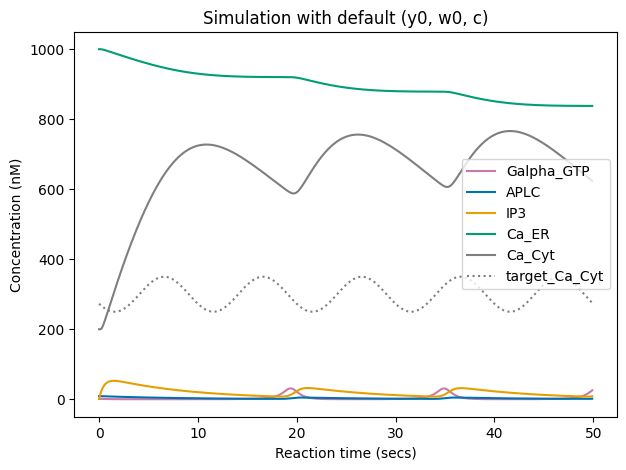

In [2]:
# load model
model_idx = 145
model, y0, w0, c = load_biomodel(model_idx)

# Run simulation
deltaT = 0.1
n_secs = 50
n_steps = int(n_secs/deltaT)
default_ys, default_ws, ts = model(n_steps, y0, w0, c)

# plot results
y_indexes = model.modelstepfunc.y_indexes
plt.figure(figsize=(7,5))
for y_label, y_idx in y_indexes.items():
    plt.plot(ts, default_ys[y_idx], label=y_label, color=default_colors[y_idx])

# plot target sine wave
target_Ca_Cyt = sine_wave(ts, A=50, w=.1, phi=10., b=300)
plt.plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color=default_colors[y_indexes["Ca_Cyt"]])

plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.title("Simulation with default (y0, w0, c)")
plt.legend()
plt.show()

We can see that the cytoplasmic $Ca^{2+}$ concentration (gray curve) already follows some oscillatory pattern, but with different signal shape and mean/amplitude/frequency than the target sine wave (dashed gray curve).

**Question: Can we modify model parameters for it to exhibit target oscillatory pattern for the cytoplasmic $Ca^{2+}$ concentration ?**

In first part of this tutorial, we will see how to do [optimization of behavior by tuning of kinematic parameters *c*](optimization-by-tuning-c), which corresponds to changing network connection weights (and could be equivalent of targeting promoter sequences or protein structures). Then, we will see how to do stimuli-based [optimization of behavior by dynamical intervention on *y* states](optimization-by-intervention-on-y), where control here is achieved by temporally regulated patterns of stimuli on specific nodes (instead of rewiring of the network structure or weights). Whereas slightly more difficult to define, optimization via temporally regulated patterns of stimuli is interesting from a biomedical perspective.

(optimization-by-tuning-c)=
## Optimization of behavior by tuning of kinematic parameters *c*

Let's start by optimizing kinematic parameters $c$ toward the desired sine wave pattern `target_Ca_Cyt`.
As we can see below, we can integrate SBMLtoODEjax models with Optax pipeline by (i) defining loss function (with respect to parameters $c$) that runs the SBMLtoODEjax model simulation,
(ii) defining the update step function (which computes derivatives of the loss function and then updates $c$ accordingly), and (iii) running the typical optimization loop, here with `optax.adam` optimizer and no learning rate scheduler. 

In [3]:
# Load Model
model, y0, w0, c = load_biomodel(model_idx)

# Optax pipeline
@jit
def loss_fn(c, model): 
    """loss function"""
    ys, ws, ts = model(n_steps, y0, w0, c)
    loss = jnp.sqrt(jnp.square(ys[y_indexes["Ca_Cyt"]]
                               -target_Ca_Cyt).sum())
    return loss

@jit
def make_step(c, model, opt_state):
    """update function"""
    loss, grads = value_and_grad(loss_fn)(c, model)
    updates, opt_state = optim.update(grads, opt_state)
    c = optax.apply_updates(c, updates)
    return loss, c, opt_state

n_optim_steps = 1000
optim = optax.adam(1e-3)
opt_state = optim.init(c)
train_loss = []
for optim_step_idx in range(n_optim_steps):
    loss, c, opt_state = make_step(c, model, opt_state)
    train_loss.append(loss)

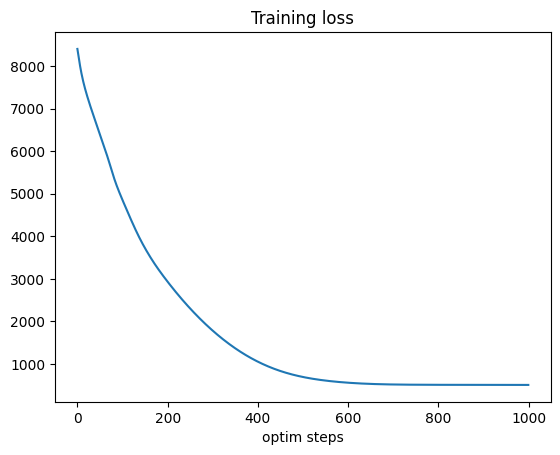

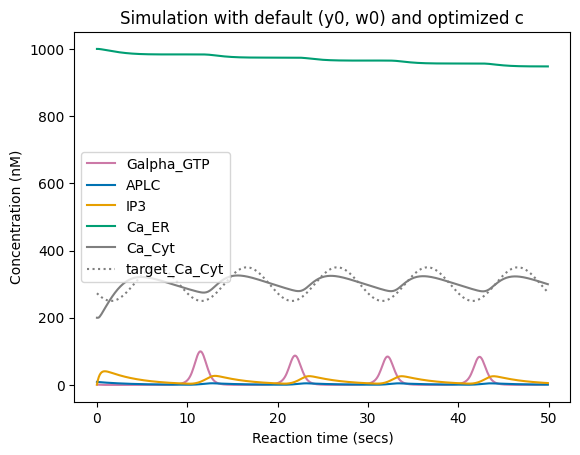

In [4]:
# Plot train loss
plt.figure()
plt.plot(train_loss)
plt.xlabel("optim steps")
plt.title("Training loss")
plt.show()

# Plot simulation results with optimized c
ys, ws, ts = model(n_steps, y0, w0, c)

plt.figure()
for y_label, y_idx in y_indexes.items():
    plt.plot(ts, ys[y_idx], label=y_label, color=default_colors[y_idx])
plt.plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color=default_colors[y_indexes["Ca_Cyt"]])
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.legend()
plt.title("Simulation with default (y0, w0) and optimized c")
plt.show()

We can see that here, the optimization successfully learned to modify kinematic parameters $c$ to minimize training loss (from $\sim 8400$ to $\sim 500$).
When running simulation with the optimized parameters $c$, we can see that the cytoplasmic $Ca^{2+}$ concentration follows an oscillatory pattern close to target one with similar mean and frequency, but does not match perfectly the target pattern, either because it is simply not feasible given the network structure and initial conditions or because optimization is stuck in a local minima.

Below, we run the same simulation for longer reaction time (100 secs). We can see that the tuning of $c$ led to long-lasting changes, as the cytoplasmic $Ca^{2+}$ concentration keeps the same oscillatory behavior even after time seen during training (50 secs). This is expected as we modified the network connection weights.

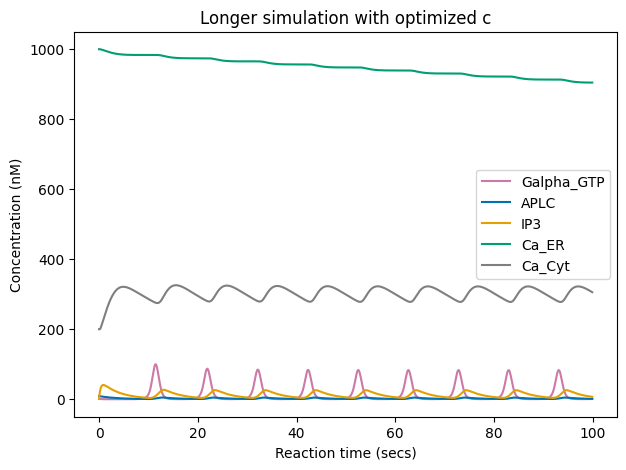

In [5]:
# longer rollout
long_ys, long_ws, long_ts = model(n_steps*2, y0, w0, c)

plt.figure(figsize=(7,5))
for y_label, y_idx in y_indexes.items():
    plt.plot(long_ts, long_ys[y_idx], label=y_label, color=default_colors[y_idx])
plt.legend()
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.title("Longer simulation with optimized c")
plt.show()

(optimization-by-intervention-on-y)=
## Optimization of behavior by dynamical intervention on *y* states

In this section, we will see how to perform more advanced interventions on the node dynamical states $y$.
To do so, let's first define a wrapper on the model rollout module that allows, during the model rollout, to apply interventions that set some node states to controlled values.

In [6]:
class ModelRolloutWithIntervention(eqx.Module):
    deltaT: float = eqx.static_field()
    modelstep_fn: eqx.Module

    def __init__(self, deltaT, modelstep_fn):

        self.deltaT = deltaT
        self.modelstep_fn = modelstep_fn

    @partial(jit, static_argnames=("n_steps",))
    def __call__(self, n_steps, y0, w0, c, intervention_ts, intervention_ys, t0=0.):

        @jit
        def f(carry, x):
            y, w, c, t = carry
            y, w, c, t = self.modelstep_fn(y, w, c, t, self.deltaT)
            
            # Add intervention
            interval_idx = self.time_to_interval(t, intervention_ts)
            y = lax.cond((interval_idx + 1).sum() > 0, self.apply_intervention, self.apply_null, y, intervention_ys, interval_idx)
            
            return (y, w, c, t), (y, w, t)
        (y, w, c, t), (ys, ws, ts) = lax.scan(f, (y0, w0, c, t0), jnp.arange(n_steps))
        ys = jnp.moveaxis(ys, 0, -1)
        ws = jnp.moveaxis(ws, 0, -1)
        return ys, ws, ts

    @jit
    def time_to_interval(self, t, intervention_ts):
        """
        returns -1 if t not in intervention_ts, else return corresponding interval
        """
        return jnp.where((t - intervention_ts) < deltaT / 10, size=1, fill_value=-1)[0][0]
    
    @jit
    def apply_intervention(self, y, intervention_ys, interval_idx):
        for y_idx in intervention_ys.keys():
            y = y.at[y_idx].set(intervention_ys[y_idx][interval_idx])
        return y
    
    @jit
    def apply_null(self, y, intervention_ys, interval_idx=-1):
        return y
    
model, y0, w0, c = load_biomodel(model_idx)
model = ModelRolloutWithIntervention(deltaT, model.modelstepfunc)

We can then define the loss function and optimizer update step as before, but this time the loss function is defined with respect to intervention parameters `intervention_ys` .

In [7]:
@eqx.filter_jit
def loss_fn(intervention_ys, model):
    ys, ws, ts = model(n_steps, y0, w0, c, intervention_ts, intervention_ys)
    loss = jnp.sqrt(jnp.square(ys[y_indexes["Ca_Cyt"]] - target_Ca_Cyt).sum())
    return loss


@eqx.filter_jit
def make_step(intervention_ys, model, opt_state):
    loss, grads = value_and_grad(loss_fn)(intervention_ys, model)
    updates, opt_state = optim.update(grads, opt_state)
    intervention_ys = optax.apply_updates(intervention_ys, updates)
    return loss, intervention_ys, opt_state

Here, the intervention parameters `intervention_ys` is 2x500 and is used to set the values of nodes `Galpha_GTP` and `IP3` during 500 first time steps (50 secs), in a free manner.

We try two different initializations: 

* `intervention_ys_init_1` which is the default values of nodes `Galpha_GTP` and `IP3` (as obtained when simulating with default parameters $c$ and initial conditions $y_0, w_0$) 
* `intervention_ys_init_2` which makes `Galpha_GTP` and `IP3` initially follow a predefined sine wave pattern (but the optimizer can then modify the parameters in a free manner)

In [8]:
intervention_ts = deepcopy(ts)

intervention_ys_init_1 = {y_indexes["Galpha_GTP"]: deepcopy(default_ys[y_indexes["Galpha_GTP"]]), 
                          y_indexes["IP3"]:  deepcopy(default_ys[y_indexes["IP3"]])}
ys_1, _, _ = model(n_steps, y0, w0, c, intervention_ts, intervention_ys_init_1)

intervention_ys_init_2 = {y_indexes["Galpha_GTP"]: sine_wave(intervention_ts, A=10, w=.1, phi=0., b=50),
                          y_indexes["IP3"]: sine_wave(intervention_ts, A=10, w=.1, phi=0., b=5)}
ys_2, _, _ = model(n_steps, y0, w0, c, intervention_ts, intervention_ys_init_2)

Let's now run the optimization with standard Optax pipeline as before, starting from the two proposed initializations.

In [9]:
# Optim from init 1
n_optim_steps = 3000
optim = optax.adam(1e-2)

intervention_ys = deepcopy(intervention_ys_init_1)
opt_state = optim.init(intervention_ys)
train_loss_1 = []

for optim_step_idx in range(n_optim_steps):
    loss, intervention_ys, opt_state = make_step(intervention_ys, model, opt_state)
    train_loss_1.append(loss)
    
optimized_ys_1, _, _ = model(n_steps, y0, w0, c, intervention_ts, intervention_ys)

In [10]:
# Optim from init 2
n_optim_steps = 3000
optim = optax.adam(1e-2)

intervention_ys = deepcopy(intervention_ys_init_2)
opt_state = optim.init(intervention_ys)
train_loss_2 = []

for optim_step_idx in range(n_optim_steps):
    loss, intervention_ys, opt_state = make_step(intervention_ys, model, opt_state)
    train_loss_2.append(loss)
    
optimized_ys_2, _, _ = model(n_steps, y0, w0, c, intervention_ts, intervention_ys)

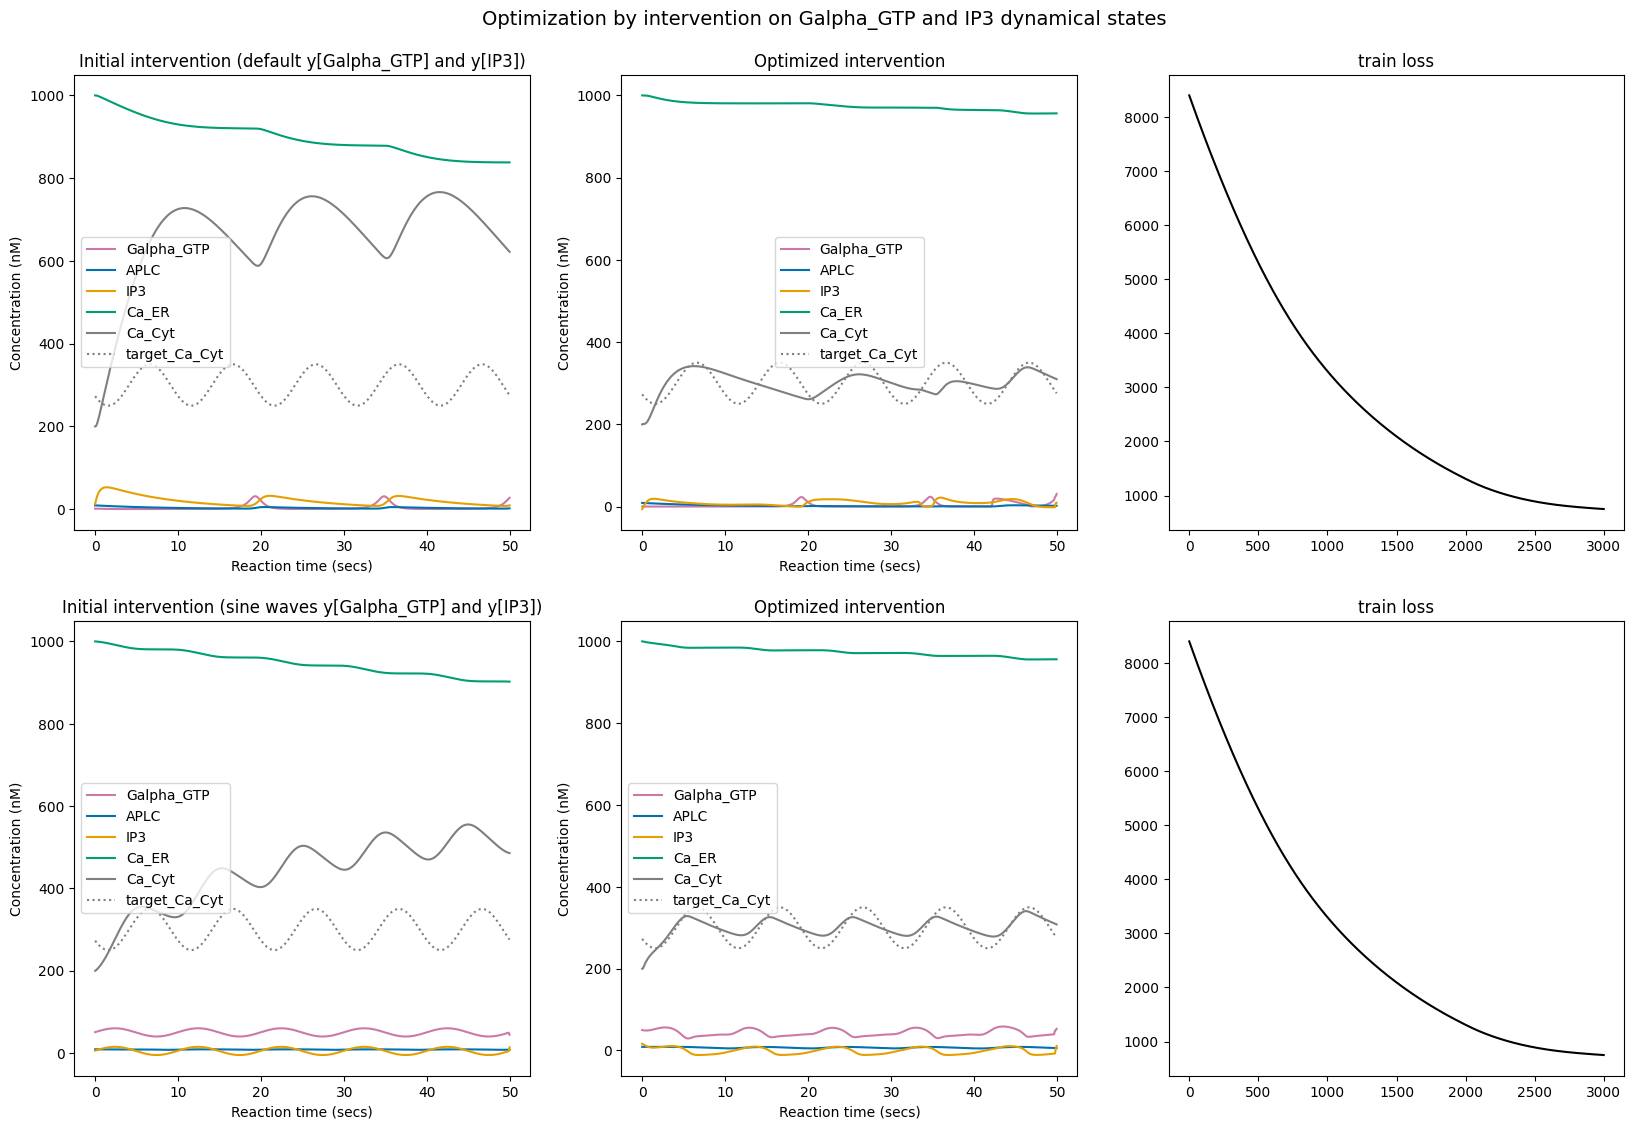

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(20,13))

for y_label, y_idx in y_indexes.items():
    ax[0, 0].plot(ts, ys_1[y_idx], label=y_label, color=default_colors[y_idx])
    ax[0, 1].plot(ts, optimized_ys_1[y_idx], label=y_label, color=default_colors[y_idx])
    ax[1, 0].plot(ts, ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    ax[1, 1].plot(ts, optimized_ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    
for i in range(2):
    for j in range(2):
        ax[i, j].plot(ts, target_Ca_Cyt, label="target_Ca_Cyt", linestyle=":", color=default_colors[y_indexes["Ca_Cyt"]])
        ax[i, j].set_xlabel("Reaction time (secs)")
        ax[i, j].set_ylabel("Concentration (nM)")
        ax[i, j].legend()
    
    ax[i, 2].plot(train_loss_1, color=default_colors[-1])

ax[0, 0].set_title("Initial intervention (default y[Galpha_GTP] and y[IP3])")
ax[0, 1].set_title("Optimized intervention")
ax[0, 2].set_title("train loss")
ax[1, 0].set_title("Initial intervention (sine waves y[Galpha_GTP] and y[IP3])")
ax[1, 1].set_title("Optimized intervention")
ax[1, 2].set_title("train loss")

fig.suptitle("Optimization by intervention on Galpha_GTP and IP3 dynamical states", y=0.93, fontsize=14)
plt.show()

We can see that once again, for both tested initializations, the optimization successfully learned to modify the intervention values on nodes `Galpha_GTP` and `IP3` to minimize the training loss.
However, one again the optimization is not perfect and more importantly the choice of initialization seems to have a big impact on the final behavior, suggesting that there are several local minimas that optimization can get stuck into. For instance here we can see that the second optimization led to some clean oscillatory cytoplasmic $Ca^{2+}$ concentration (similar to what we obtained when tuning $c$) whereas the first optimization led to more chaotic oscillatory pattern. 

However, when we run the simulation for longer reaction time (100 secs), we can see that contrary to the long-lasting changes obtained by tuning $c$ here the signal converges back to some relaxed oscillatory pattern as soon as we stop sending the regulated pattern stimuli. This does not mean that perturbation via pulsed stimuli cannot induce long-lasting changes, but that it might require more advanced search and optimization strategies.

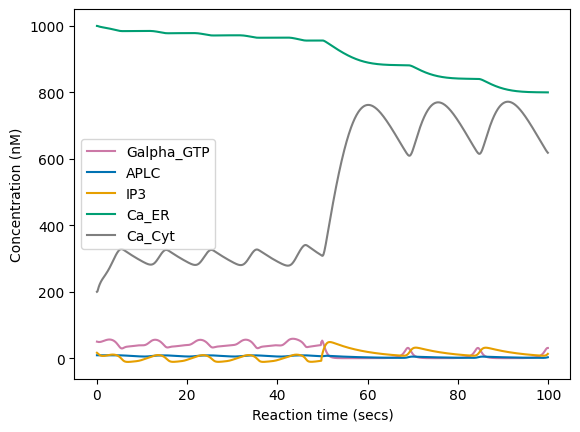

In [12]:
# longer rollout
fig = plt.figure()

long_optimized_ys_2, _, _ = model(n_steps*2, y0, w0, c, intervention_ts, intervention_ys)
for y_label, y_idx in y_indexes.items():
    plt.plot(long_ts, long_optimized_ys_2[y_idx], label=y_label, color=default_colors[y_idx])
    
plt.xlabel("Reaction time (secs)")
plt.ylabel("Concentration (nM)")
plt.legend()
plt.show()

##  ⚠️ Limitations

Whereas performing automatic differentiation and gradient-descent based optimization on SBML models parameters and/or dynamical states opens many possibilities to design interventions on existing models (and potentially to transpose those in vitro), or to design new models with target properties (e.g. for synthetic circuit engineering), we found that gradient-based optimization can be hard in those models for the following reasons:

1. Here the rollout time is quite short at training time (T=50 secs) but the backward pass for computing the gradient is already quite involved and can be relatively long to compute (and quickly intractable when considering longer rollouts)
2. Whereas gradient-based optimization can be very efficient when backpropagating though conventional neural network layers and architectures (e.g. linear and convolutional layers), here the gradient signal can be exploding or vanishing and hard to exploit, leading very often to NaN values. This is because the backprop needs to go through all recurrent calls of the `modelstepfunc` which itself calls JAX `odeint` solver which itself must integrate a complex system of differential equations (which can take many forms). This could probably be improved by considering simpler SBML models (e.g. synthetic networks with common operations) and simpler ODE solver (e.g. simple Euler integration method)
3. Due to the non-linearity and complexity of the dynamics involved, the optimization landscape can be very hard and have a lot of local minimas. More advanced exploration methods might be necessary, in coupling with gradient-based optimization, for successfull optimization. 

Whereas we focused this tutorial on gradient-based optimization of SBML models, many other optimization methods can be envisaged in particular evolutionary algorithms which might take advantage of SBMLtoODEjax parallel execution capabilities.